In [ ]:
import csv
import re

input_file = "../RAW_DATA/838_all_comment.csv"
output_file = "cleaned_comments_cleaned.csv"

def clean_text(text):
    if isinstance(text, str):
        text = text.replace(',', ' ')  # **確保 `,` 不影響 CSV 解析**
        text = text.replace('\n', ' ')  # **移除換行符**
        text = re.sub(r'\s+', ' ', text).strip()  # **去除多餘空格**
    return text

with open(input_file, "r", encoding="utf-8") as fin, open(output_file, "w", encoding="utf-8", newline='') as fout:
    reader = csv.reader(fin, quotechar='"', delimiter=',')
    writer = csv.writer(fout, quoting=csv.QUOTE_MINIMAL)  # **確保 CSV 格式正確**

    header = next(reader)  # 讀取標題列
    writer.writerow(header)

    for row in reader:
        if len(row) >= 8:  # **確保 `comments` 欄位存在**
            row[7] = clean_text(row[7])  # **只清理 `comments` 欄位**
        writer.writerow(row)

print("`comments` 清理完成")


In [2]:
import pandas as pd

# 讀取 CSV（請確保檔案名稱正確）
csv_file = "cleaned_comments_cleaned.csv"

# 讀取 CSV，僅保留必要欄位
df = pd.read_csv(csv_file, usecols=['review_id', 'location_ID', 'comments', 'language'])

# 移除空評論
df = df.dropna(subset=['comments', 'language'])

# 顯示前 5 筆，確認資料格式
print(df.head())

# 儲存過濾後的 CSV（如果未來需要重新使用）
df.to_csv("cleaned_comments.csv", index=False)
print(f"有效評論數量: {len(df)}")


                             location_ID  \
0  0x346885034084ae89:0x59a8b1eac5731c29   
1  0x346885034084ae89:0x59a8b1eac5731c29   
2  0x346885034084ae89:0x59a8b1eac5731c29   
3  0x346885034084ae89:0x59a8b1eac5731c29   
4  0x346885034084ae89:0x59a8b1eac5731c29   

                              review_id  \
0   ChZDSUhNMG9nS0VJQ0FnTURBM3RueUd3EAE   
1   ChZDSUhNMG9nS0VJQ0FnSURQbDdIOWZREAE   
2   ChZDSUhNMG9nS0VJQ0FnSURINzR1MUN3EAE   
3  ChdDSUhNMG9nS0VJQ0FnSURIdV9pYnFBRRAB   
4   ChZDSUhNMG9nS0VJQ0FnSURIanJHb2ZnEAE   

                                            comments language  
0                                  在0403的地震就崩壞了，過不去了  zh-Hant  
1  給一日遊，請先做功課喔， 113/12/5天氣晴，查網路：蘇花，中橫順暢， 想著沿途，中橫施...  zh-Hant  
2  太魯閣水簾洞：大自然鬼斧神工的傑作 太魯閣，這片鬼斧神工的峽谷，處處是令人驚嘆的自然景觀。其...  zh-Hant  
3                              2022/9 第一次走時 眼前景是真的震撼  zh-Hant  
4  2024/3/22 太魯閣最喜歡的步道，本身很喜歡瀑布跟險峻的山，這裡剛好綜合了我的喜好。 ...  zh-Hant  
有效評論數量: 2759814


In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

# 載入 Sentence Transformers 模型
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2', device='cuda')

# 轉換為向量（批次處理）
batch_size = 512
comment_vectors = []
review_ids = []

for i in range(0, len(df), batch_size):
    batch_comments = df['comments'][i:i+batch_size].tolist()
    batch_vectors = model.encode(batch_comments, convert_to_numpy=True)
    
    comment_vectors.append(batch_vectors)
    review_ids.extend(df['review_id'][i:i+batch_size].tolist())

# 合併所有向量
comment_vectors = np.vstack(comment_vectors).astype('float32')

# 儲存向量（方便未來使用）
np.save("comment_vectors.npy", comment_vectors)
np.save("review_ids.npy", review_ids)

print(f"已向量化 {len(comment_vectors)} 條評論")

已向量化 2759814 條評論


#### 請先至conda prompt 安裝 FAISS GPU版本
`conda install conda-forge::faiss-gpu`

In [ ]:
# 如kernel關閉或重啟，需要先load向量儲存檔

import numpy as np

# 讀取先前儲存的向量與 review_id
comment_vectors = np.load("comment_vectors.npy")
review_ids = np.load("review_ids.npy")

In [4]:
import faiss

# 向量維度
d = comment_vectors.shape[1]

# 設定 1024 個 cluster
num_clusters = 1024
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, num_clusters, faiss.METRIC_L2)

# 訓練 FAISS（僅需執行一次）
index.train(comment_vectors)
index.add(comment_vectors)

# 儲存 FAISS 索引
faiss.write_index(index, "faiss_index_ivf.bin")

print(f"FAISS IVFFlat 索引已建立，儲存完成！")

FAISS IVFFlat 索引已建立，儲存完成！


#### 為確保最佳群數，採用Elbow Method
- 先從向量中採樣，每個地點10%的評論、上限300
- 確保冷門景點也可以被採樣到

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# 讀取評論向量
comment_vectors = np.load("comment_vectors.npy")
df = pd.read_csv("cleaned_comments.csv")  

# 確保 location_ID 是字串格式
df['location_ID'] = df['location_ID'].astype(str)

# 讓評論對應到向量
df['vector'] = list(comment_vectors)

# 設定公平採樣策略
sampled_vectors = []
sampled_review_ids = []
sampled_location_ids = []

for location_id, group in df.groupby("location_ID"):
    sample_size = min(len(group) // 10, 300)  # 取 10% 或最多 300 筆
    sampled_data = group.sample(n=sample_size, random_state=42)
    
    sampled_vectors.extend(sampled_data['vector'].tolist())
    sampled_review_ids.extend(sampled_data['review_id'].tolist())
    sampled_location_ids.extend([location_id] * sample_size)

sampled_vectors = np.array(sampled_vectors)

# 儲存公平採樣後的向量與對應的評論 ID
np.save("sampled_vectors.npy", sampled_vectors)
np.save("sampled_review_ids.npy", sampled_review_ids)
np.save("sampled_location_ids.npy", sampled_location_ids)

print(f"公平採樣完成，共選取 {len(sampled_vectors)} 筆評論進行分群")


使用 MiniBatchKMeans 測試 K = 2 ~ 20，採樣 129141 筆評論向量


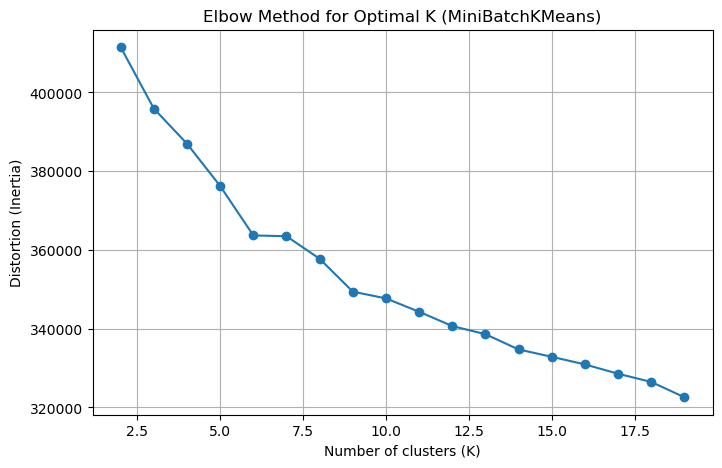

Elbow Method 完成！請觀察圖表中的「拐點」，決定最佳的 K 值


In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# 讀取公平採樣的向量
sampled_vectors = np.load("sampled_vectors.npy")

# 設定 K 值範圍
K_range = range(2, 20)
distortions = []

print(f"使用 MiniBatchKMeans 測試 K = 2 ~ 20，採樣 {len(sampled_vectors)} 筆評論向量")

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=3072, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(sampled_vectors)
    distortions.append(kmeans.inertia_)

# 繪製 Elbow Method 圖
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K (MiniBatchKMeans)')
plt.grid(True)
plt.show()

print("Elbow Method 完成！請觀察圖表中的「拐點」，決定最佳的 K 值")


#### 開始分群囉

In [11]:
import faiss
import numpy as np
import pandas as pd

# 讀取 FAISS 索引
index = faiss.read_index("faiss_index_ivf.bin")
d = index.d  # 獲取向量維度

# 取得所有評論向量
all_vectors = np.zeros((index.ntotal, d), dtype='float32')
index.reconstruct_n(0, index.ntotal, all_vectors)

# 執行 FAISS K-means 分群
num_clusters = 6  # 來自 Elbow Method(一開始跑10)
kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=100, verbose=True)
kmeans.train(all_vectors)

# 取得每條評論的分類標籤
_, cluster_labels = kmeans.index.search(all_vectors, 1)  # 確保這裡取得的是 K-means 結果

# 讀取原始評論數據
df = pd.read_csv("cleaned_comments.csv", usecols=["location_ID", "review_id"])  # 只讀取必要欄位

# 加入 cluster 分群結果
df['cluster'] = cluster_labels.flatten()

# **確保不存入完整向量**
df.to_csv("clustered_comments_6.csv", index=False, mode="w")

print("FAISS K-means 分群完成，已儲存 `clustered_comments.csv`（僅包含 location_ID, review_id, cluster）")


FAISS K-means 分群完成，已儲存 `clustered_comments.csv`（僅包含 location_ID, review_id, cluster）


In [12]:
import pandas as pd
import numpy as np

# 讀取完整評論的分群結果
df = pd.read_csv("clustered_comments_6.csv")  # 這是 K-means 分群的結果
df['location_ID'] = df['location_ID'].astype(str)  # 確保 `location_ID` 是字串

# 計算每個地點的主要分類 & 總評論數
df_major_category = df.groupby(['location_ID'])['cluster'].agg([
    ('主分類', lambda x: x.value_counts().idxmax()),  # 取得最多評論的分類
    ('該分類比例', lambda x: x.value_counts().max() / len(x)),  # 取得該分類的佔比
    ('總評論數', 'count')  # 該地點的總評論數
]).reset_index()

# 讀取地點資訊 JSON
df_info = pd.read_json("../RAW_DATA/838_location_info.json")
df_info['location_id'] = df_info['location_id'].astype(str)

# **修正 `gmp_location` 錯誤的欄位名稱**
df_info = df_info.rename(columns={"gmp_location": "gmap_location"})

# **確保 `location_ID` 和 `location_id` 一致**
df_major_category = df_major_category.merge(df_info[['location_id', 'gmap_location']], 
                                            left_on='location_ID', right_on='location_id', how='left')

# 刪除 `location_id`（避免重複欄位）
df_major_category.drop(columns=['location_id'], inplace=True)

# **標記「低樣本數」的地點**
df_major_category['分類品質'] = df_major_category['總評論數'].apply(lambda x: "低樣本數" if x < 10 else "OK")

# 儲存結果（這是新的地點分類結果）
df_major_category.to_csv("location_major_category_review_analysis_6.csv", index=False)

print("已計算每個地點的主要分類，請查看 `location_major_category_review_analysis.csv` 進行人工審核！")


已計算每個地點的主要分類，請查看 `location_major_category_review_analysis.csv` 進行人工審核！


#### 產生了 `k = 6` 以及 `k = 10` 兩種分群
- 6群效果不理想  
- 10群效果尚可，但仍有部分地點很難與群組做連結，例如眾多寺廟、教堂，與台北小巨蛋

#### 決定進行以下作業
- 篩選評論長度小於 `10` 的評論
- 只保留主要語言 `["zh-Hant", "zh", "en", "ja", "ko", "th", "vi", "id", "fr", "de", "it", "es"]`
- 如上述效果仍有改進空間，就把 `summary_1、summary_2` 以權重 `0.2` 的方式加入一起判斷，避免過多人為因素影響分群

In [ ]:
import pandas as pd

# 讀取原始評論數據
df = pd.read_csv("cleaned_comments.csv")

# 目標語言清單
target_languages = ["zh-Hant","en", "ja", "ko", "th", "vi", "id"]

# 過濾非目標語言的評論
df_filtered = df[df["language"].isin(target_languages)]

# 移除過短的評論（少於 10 個字）
df_filtered = df_filtered[df_filtered["comments"].str.len() >= 10]

# 儲存過濾後的數據
df_filtered.to_csv("cleaned_comments_new.csv", index=False)

print(f"過濾完成，保留 {len(df_filtered)} 則評論，移除 {len(df) - len(df_filtered)} 則評論")


過濾完成，保留 1844295 則評論，移除 915519 則評論


In [17]:
print(df_filtered.head())

                             location_ID  \
0  0x346885034084ae89:0x59a8b1eac5731c29   
1  0x346885034084ae89:0x59a8b1eac5731c29   
2  0x346885034084ae89:0x59a8b1eac5731c29   
3  0x346885034084ae89:0x59a8b1eac5731c29   
4  0x346885034084ae89:0x59a8b1eac5731c29   

                              review_id  \
0   ChZDSUhNMG9nS0VJQ0FnTURBM3RueUd3EAE   
1   ChZDSUhNMG9nS0VJQ0FnSURQbDdIOWZREAE   
2   ChZDSUhNMG9nS0VJQ0FnSURINzR1MUN3EAE   
3  ChdDSUhNMG9nS0VJQ0FnSURIdV9pYnFBRRAB   
4   ChZDSUhNMG9nS0VJQ0FnSURIanJHb2ZnEAE   

                                            comments language  
0                                  在0403的地震就崩壞了，過不去了  zh-Hant  
1  給一日遊，請先做功課喔， 113/12/5天氣晴，查網路：蘇花，中橫順暢， 想著沿途，中橫施...  zh-Hant  
2  太魯閣水簾洞：大自然鬼斧神工的傑作 太魯閣，這片鬼斧神工的峽谷，處處是令人驚嘆的自然景觀。其...  zh-Hant  
3                              2022/9 第一次走時 眼前景是真的震撼  zh-Hant  
4  2024/3/22 太魯閣最喜歡的步道，本身很喜歡瀑布跟險峻的山，這裡剛好綜合了我的喜好。 ...  zh-Hant  


In [18]:
from sentence_transformers import SentenceTransformer
import numpy as np

# 載入 Sentence Transformers 模型
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2', device='cuda')

# 轉換為向量（批次處理）
batch_size = 512
comment_vectors = []
review_ids = []

for i in range(0, len(df_filtered), batch_size):
    batch_comments = df_filtered['comments'][i:i+batch_size].tolist()
    batch_vectors = model.encode(batch_comments, convert_to_numpy=True)
    
    comment_vectors.append(batch_vectors)
    review_ids.extend(df_filtered['review_id'][i:i+batch_size].tolist())

# 合併所有向量
comment_vectors = np.vstack(comment_vectors).astype('float32')

# 儲存向量（方便未來使用）
np.save("comment_vectors_new.npy", comment_vectors)
np.save("review_ids_new.npy", review_ids)

print(f"已向量化 {len(comment_vectors)} 條評論")

c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


已向量化 1844295 條評論


In [19]:
import faiss

# 向量維度
d = comment_vectors.shape[1]

# 設定 1024 個 cluster
num_clusters = 1024
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, num_clusters, faiss.METRIC_L2)

# 訓練 FAISS（僅需執行一次）
index.train(comment_vectors)
index.add(comment_vectors)

# 儲存 FAISS 索引
faiss.write_index(index, "faiss_index_ivf_new.bin")

print(f"FAISS IVFFlat 索引已建立，儲存完成！")

FAISS IVFFlat 索引已建立，儲存完成！


In [20]:
import faiss
import numpy as np
import pandas as pd

# 讀取 FAISS 索引
index = faiss.read_index("faiss_index_ivf_new.bin")
d = index.d  # 獲取向量維度

# 取得所有評論向量
all_vectors = np.zeros((index.ntotal, d), dtype='float32')
index.reconstruct_n(0, index.ntotal, all_vectors)

# 執行 FAISS K-means 分群
num_clusters = 10  # 來自 Elbow Method
kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=100, verbose=True)
kmeans.train(all_vectors)

# 取得每條評論的分類標籤
_, cluster_labels = kmeans.index.search(all_vectors, 1)  # 確保這裡取得的是 K-means 結果

# 讀取原始評論數據
df = pd.read_csv("cleaned_comments_new.csv", usecols=["location_ID", "review_id"])  # 只讀取必要欄位

# 加入 cluster 分群結果
df['cluster'] = cluster_labels.flatten()

# **確保不存入完整向量**
df.to_csv("clustered_comments_new.csv", index=False, mode="w")

print("FAISS K-means 分群完成，已儲存 `clustered_comments_new.csv`（僅包含 location_ID, review_id, cluster）")


FAISS K-means 分群完成，已儲存 `clustered_comments_new.csv`（僅包含 location_ID, review_id, cluster）


In [21]:
import pandas as pd
import numpy as np

# 讀取完整評論的分群結果
df = pd.read_csv("clustered_comments_new.csv")  # 這是 K-means 分群的結果
df['location_ID'] = df['location_ID'].astype(str)  # 確保 `location_ID` 是字串

# 計算每個地點的主要分類 & 總評論數
df_major_category = df.groupby(['location_ID'])['cluster'].agg([
    ('主分類', lambda x: x.value_counts().idxmax()),  # 取得最多評論的分類
    ('該分類比例', lambda x: x.value_counts().max() / len(x)),  # 取得該分類的佔比
    ('總評論數', 'count')  # 該地點的總評論數
]).reset_index()

# 讀取地點資訊 JSON
df_info = pd.read_json("../RAW_DATA/838_location_info.json")
df_info['location_id'] = df_info['location_id'].astype(str)

# **修正 `gmp_location` 錯誤的欄位名稱**
df_info = df_info.rename(columns={"gmp_location": "gmap_location"})

# **確保 `location_ID` 和 `location_id` 一致**
df_major_category = df_major_category.merge(df_info[['location_id', 'gmap_location']], 
                                            left_on='location_ID', right_on='location_id', how='left')

# 刪除 `location_id`（避免重複欄位）
df_major_category.drop(columns=['location_id'], inplace=True)

# **標記「低樣本數」的地點** 這次我改成50
df_major_category['分類品質'] = df_major_category['總評論數'].apply(lambda x: "低樣本數" if x < 50 else "OK")

# 儲存結果（這是新的地點分類結果）
df_major_category.to_csv("location_major_category_review_analysis_new.csv", index=False)

print("已計算每個地點的主要分類，進行人工審核！")


已計算每個地點的主要分類，進行人工審核！


#### 看一下比例低於0.3的地點中，還有哪些分群比例較接近
- 結論是看不出所以然

In [23]:
import pandas as pd

# 讀取已分類的結果
df = pd.read_csv("clustered_comments_new.csv")

# 讀取地點的主要分類結果
df_major = pd.read_csv("location_major_category_review_analysis_new.csv")

# 合併數據，確保我們可以比對每個地點的主要分類比例
df = df.merge(df_major[['location_ID', '主分類', '該分類比例']], on="location_ID", how="left")

# 篩選「該分類比例」低於 0.3 的地點
df_low_confidence = df[df["該分類比例"] < 0.3]

# 計算這些地點的評論在不同 cluster 的分佈
df_distribution = df_low_confidence.groupby(["location_ID", "cluster"]).size().unstack(fill_value=0)

# 計算每個地點的評論總數
df_distribution["總評論數"] = df_distribution.sum(axis=1)

# 計算每個群組的比例
df_distribution = df_distribution.div(df_distribution["總評論數"], axis=0)

# 移除「總評論數」列（只顯示分類比例）
df_distribution.drop(columns=["總評論數"], inplace=True)

# 顯示結果
df_distribution.to_csv("low_confidence_location_distribution.csv")


#### 也用 `BAAI/bge-m3` 做一次看看，且日後檢索也會需要(max = 8192)

In [ ]:
from FlagEmbedding import BGEM3FlagModel
import numpy as np
import pandas as pd
import os

# 讀取數據
df = pd.read_csv("cleaned_comments_new.csv", usecols=["review_id", "comments"])

# 載入 BGE-M3 模型
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True, use_cuda=True, device=0)

# 轉換為向量（批次處理）
batch_size = 512
dense_vectors = []
#lexical_weights, colbert_vectors = [], [] #之後可以考慮加入
review_ids = []

for i in range(0, len(df), batch_size):
    batch_comments = df.iloc[i:i+batch_size]["comments"].tolist()
    batch_review_ids = df.iloc[i:i+batch_size]["review_id"].tolist()
    
    batch_results = model.encode(batch_comments)

    if isinstance(batch_results, dict):
        dense_vectors.append(np.array(batch_results["dense_vecs"]))
        #lexical_weights.append(np.array(batch_results["lexical_weights"]))
        #colbert_vectors.append(np.array(batch_results["colbert_vecs"]))
    else:
        print(f"批次 {i // batch_size + 1} 轉換失敗，跳過")
        continue

    review_ids.extend(batch_review_ids)

# 合併向量
dense_vectors = np.vstack(dense_vectors).astype('float32')
#lexical_weights = np.vstack(lexical_weights).astype('float32')
#colbert_vectors = np.vstack(colbert_vectors).astype('float32')

# 儲存所有向量
np.save("comment_vectors_bge.npy", dense_vectors)
#np.save("lexical_weights_bge.npy", lexical_weights)
#np.save("colbert_vectors_bge.npy", colbert_vectors)
np.save("review_ids_bge.npy", np.array(review_ids))

print(f"已向量化 {len(dense_vectors)} 條評論，所有向量已儲存！")


In [32]:
import faiss

# 向量維度
d = comment_vectors.shape[1]

# 設定 1024 個 cluster
num_clusters = 1024
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, num_clusters, faiss.METRIC_L2)

# 訓練 FAISS（僅需執行一次）
index.train(comment_vectors)
index.add(comment_vectors)

# 儲存 FAISS 索引
faiss.write_index(index, "faiss_index_ivf_bge.bin")

print(f"FAISS IVFFlat 索引已建立，儲存完成！")

FAISS IVFFlat 索引已建立，儲存完成！


In [33]:
import faiss
import numpy as np
import pandas as pd

# 讀取 FAISS 索引
index = faiss.read_index("faiss_index_ivf_bge.bin")
d = index.d  # 獲取向量維度

# 取得所有評論向量
all_vectors = np.zeros((index.ntotal, d), dtype='float32')
index.reconstruct_n(0, index.ntotal, all_vectors)

# 執行 FAISS K-means 分群
num_clusters = 10  # 來自 Elbow Method
kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=100, verbose=True)
kmeans.train(all_vectors)

# 取得每條評論的分類標籤
_, cluster_labels = kmeans.index.search(all_vectors, 1)  # 確保這裡取得的是 K-means 結果

# 讀取原始評論數據
df = pd.read_csv("cleaned_comments_new.csv", usecols=["location_ID", "review_id"])  # 只讀取必要欄位

# 加入 cluster 分群結果
df['cluster'] = cluster_labels.flatten()

# **確保不存入完整向量**
df.to_csv("clustered_comments_bge.csv", index=False, mode="w")

print("FAISS K-means 分群完成，已儲存 `clustered_comments_bge.csv`（僅包含 location_ID, review_id, cluster）")


FAISS K-means 分群完成，已儲存 `clustered_comments_bge.csv`（僅包含 location_ID, review_id, cluster）


In [34]:
import pandas as pd
import numpy as np

# 讀取完整評論的分群結果
df = pd.read_csv("clustered_comments_bge.csv")  # 這是 K-means 分群的結果
df['location_ID'] = df['location_ID'].astype(str)  # 確保 `location_ID` 是字串

# 計算每個地點的主要分類 & 總評論數
df_major_category = df.groupby(['location_ID'])['cluster'].agg([
    ('主分類', lambda x: x.value_counts().idxmax()),  # 取得最多評論的分類
    ('該分類比例', lambda x: x.value_counts().max() / len(x)),  # 取得該分類的佔比
    ('總評論數', 'count')  # 該地點的總評論數
]).reset_index()

# 讀取地點資訊 JSON
df_info = pd.read_json("../RAW_DATA/838_location_info.json")
df_info['location_id'] = df_info['location_id'].astype(str)

# **修正 `gmp_location` 錯誤的欄位名稱**
df_info = df_info.rename(columns={"gmp_location": "gmap_location"})

# **確保 `location_ID` 和 `location_id` 一致**
df_major_category = df_major_category.merge(df_info[['location_id', 'gmap_location']], 
                                            left_on='location_ID', right_on='location_id', how='left')

# 刪除 `location_id`（避免重複欄位）
df_major_category.drop(columns=['location_id'], inplace=True)

# **標記「低樣本數」的地點** 這次我改成50
df_major_category['分類品質'] = df_major_category['總評論數'].apply(lambda x: "低樣本數" if x < 50 else "OK")

# 儲存結果（這是新的地點分類結果）
df_major_category.to_csv("location_major_category_review_analysis_bge.csv", index=False)

print("已計算每個地點的主要分類，進行人工審核！")


已計算每個地點的主要分類，進行人工審核！


#### 分類效果依舊不是直觀上的理想狀態，思考以下:
- 認為分類不好，這是基於「直覺」，但我們需要找出「數據上的原因」
- 應該理解為何模型會這樣分類，因為模型是基於 `評論內容` 的 `向量表示` 進行分群的

In [ ]:
import pandas as pd

# 讀取分群結果（包含 review_id）
df_clusters = pd.read_csv("clustered_comments_new.csv", usecols=["cluster", "review_id", "location_ID"])

# 讀取完整評論數據（包含 review_id 和 comments）
df_comments = pd.read_csv("cleaned_comments_new.csv", usecols=["review_id", "comments"])

# 讀取地點資訊
df_info = pd.read_json("../RAW_DATA/838_location_info.json")
df_info = df_info.rename(columns={"location_id": "location_ID", "gmp_location": "gmap_location"})

# 🔹 合併評論內容
df_clusters = df_clusters.merge(df_comments, on="review_id", how="left")

# 🔹 再合併地點名稱
df_clusters = df_clusters.merge(df_info[['location_ID', 'gmap_location']], on='location_ID', how='left')

# 🔹 依 `cluster` 分群，隨機選取 10 條評論
for cluster_id, group in df_clusters.groupby("cluster"):
    print(f"\n===== 🏷️ 群組 {cluster_id} =====")
    
    # 取 10 條隨機評論（如果群組內評論數少於 10，則取全部）
    sample_reviews = group.sample(n=min(100, len(group)), random_state=42)[["gmap_location", "comments"]].values
    
    # 印出評論內容與地點名稱
    for idx, (location, comment) in enumerate(sample_reviews, 1):
        print(f"{idx}. 📍 {location} - {comment}")
    
    print("=" * 50)  # 分隔線


In [ ]:
import pandas as pd
import os

# 讀取分群結果（包含 review_id, cluster, location_ID）
df_clusters = pd.read_csv("clustered_comments_new.csv", usecols=["cluster", "review_id", "location_ID"])

# 讀取完整評論數據（包含 review_id 和 comments）
df_comments = pd.read_csv("cleaned_comments_new.csv", usecols=["review_id", "comments"])

# 讀取地點資訊
df_info = pd.read_json("../RAW_DATA/838_location_info.json")
df_info = df_info.rename(columns={"location_id": "location_ID", "gmp_location": "gmap_location"})

# 🔹 合併評論內容
df_clusters = df_clusters.merge(df_comments, on="review_id", how="left")

# 🔹 再合併地點名稱
df_clusters = df_clusters.merge(df_info[['location_ID', 'gmap_location']], on='location_ID', how='left')

# 🔹 只保留 `cluster`、`gmap_location`（地點名稱）、`comments`（評論內容）
df_clusters = df_clusters[["cluster", "gmap_location", "comments"]]

# 🔹 每個群組隨機選取 200 條評論（如果該群組少於 200，則取全部）
df_sample = df_clusters.groupby("cluster").apply(lambda x: x.sample(n=min(200, len(x)), random_state=42)).reset_index(drop=True)

# 🔹 儲存成單一 CSV 檔案
output_path = "cluster_sampled_reviews.csv"
df_sample.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"已輸出 {len(df_sample)} 條評論到 `{output_path}`")
